##### Master Degree in Computer Science and Data Science for Economics

# Toy example of a Transformer

### Alfio Ferrara

- token & positional embeddings
- single-head scaled dot-product self-attention with **causal mask**
- residual connections + **LayerNorm** (pre-norm)
- 2-layer **Feed-Forward** (GELU)
- output head to vocabulary logits
- tiny next-token task, training loop, loss curve
- **attention heatmap** visualization

In [7]:
import math
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

@dataclass
class Config:
    d_model: int = 4
    n_heads: int = 1     # single head for clarity
    d_ff: int = 8
    vocab_size: int = 10
    max_len: int = 8
    num_layers: int = 1
    device: str = "cpu"
    lr: float = 0.02
    steps: int = 200     # adjust if you want it faster/slower
    seed: int = 0

cfg = Config()
torch.manual_seed(cfg.seed)

def causal_mask(seq_len):
    mask = torch.ones(seq_len, seq_len, dtype=torch.bool).tril()
    return mask.view(1, 1, seq_len, seq_len)


In [8]:
class SingleHeadSelfAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        self.last_attn = None  # store for visualization

    def forward(self, x, attn_mask=None, store_attn=False):
        B, T, D = x.shape
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        scores = (Q @ K.transpose(-2, -1)) / math.sqrt(D)  # [B,T,T]
        if attn_mask is not None:
            scores = scores.masked_fill(~attn_mask.squeeze(1), float("-inf"))
        attn = torch.softmax(scores, dim=-1)
        out  = attn @ V
        out  = self.W_o(out)
        if store_attn:
            self.last_attn = attn[0].detach().cpu()
        return out

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        return self.fc2(F.gelu(self.fc1(x)))

class TinyTransformerBlock(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.sa  = SingleHeadSelfAttention(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(d_model, d_ff)
    def forward(self, x, attn_mask=None, store_attn=False):
        x = x + self.sa(self.ln1(x), attn_mask=attn_mask, store_attn=store_attn)
        x = x + self.ffn(self.ln2(x))
        return x

class TinyTransformer(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg.vocab_size, cfg.d_model)
        self.pos_emb = nn.Embedding(cfg.max_len, cfg.d_model)
        self.blocks  = nn.ModuleList([TinyTransformerBlock(cfg.d_model, cfg.d_ff) for _ in range(cfg.num_layers)])
        self.ln_f    = nn.LayerNorm(cfg.d_model)
        self.head    = nn.Linear(cfg.d_model, cfg.vocab_size)
    def forward(self, idx, store_attn=False):
        B, T = idx.shape
        pos = torch.arange(T, device=idx.device).unsqueeze(0).expand(B, T)
        x = self.tok_emb(idx) + self.pos_emb(pos)
        mask = causal_mask(T).to(idx.device)
        for i, block in enumerate(self.blocks):
            x = block(x, attn_mask=mask, store_attn=(store_attn and i == len(self.blocks)-1))
        x = self.ln_f(x)
        return self.head(x)
    def last_attention(self):
        return self.blocks[-1].sa.last_attn


In [12]:
# tiny next-token prediction sequences
base = torch.tensor([[0,1,2,3,4,5],
                     [1,2,3,4,5,6]], dtype=torch.long)
targets = torch.tensor([[2,3,4,5,6,8],
                        [3,4,5,6,8,9]], dtype=torch.long)


In [13]:
model = TinyTransformer(cfg).to(cfg.device)
opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr)

loss_history = []
for step in range(cfg.steps):
    logits = model(base, store_attn=(step == cfg.steps-1))
    loss = F.cross_entropy(logits.view(-1, cfg.vocab_size), targets.view(-1))
    opt.zero_grad(); loss.backward(); opt.step()
    loss_history.append(loss.item())

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")
print(f"Final training loss: {loss_history[-1]:.4f}")


Total parameters: 286
Final training loss: 0.0038


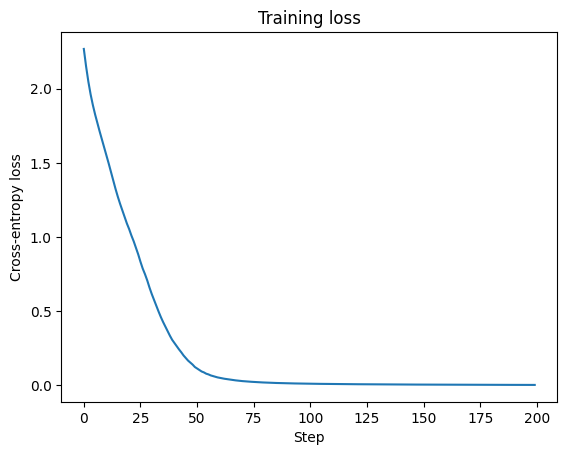

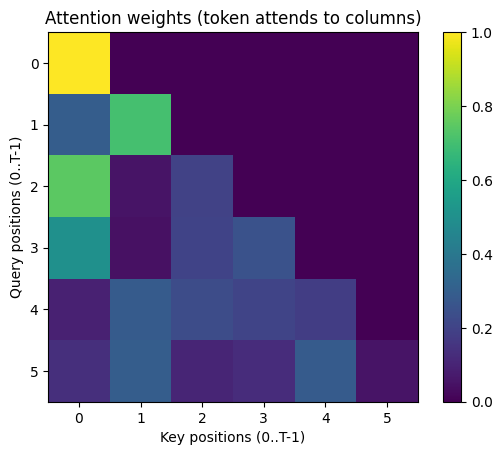

In [15]:
# 1) Loss curve
plt.figure()
plt.plot(loss_history)
plt.title("Training loss")
plt.xlabel("Step")
plt.ylabel("Cross-entropy loss")
plt.show()

# 2) Attention heatmap from last forward pass
attn = model.last_attention()
if attn is not None:
    plt.figure()
    plt.imshow(attn)
    plt.title("Attention weights (token attends to columns)")
    plt.xlabel("Key positions (0..T-1)")
    plt.ylabel("Query positions (0..T-1)")
    plt.colorbar()
    plt.show()
else:
    print("No stored attention to visualize.")


In [16]:
base = torch.tensor([[0,1,2,3,4,5],
                     [1,2,3,4,5,6]], dtype=torch.long)
logits = model(base, store_attn=(step == cfg.steps-1))

In [21]:
logits[0][5]

tensor([-1.3760, -1.2568, -0.1283, -7.3101, -0.1235, -1.0669, -7.8744, -1.5155,
         7.3216, -0.1650], grad_fn=<SelectBackward0>)